In [6]:
import os

import pandas as pd
import numpy as np
import scipy as sp

import math

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

out_dir = "../../data/05_reporting/problem_set_2"

In [7]:
# helper functions

def load_data(fpath: str | os.PathLike = "../../data/01_raw/penguins.csv"
              ) -> pd.DataFrame:
    """Load penguins dataset."""
    return pd.read_csv(fpath)


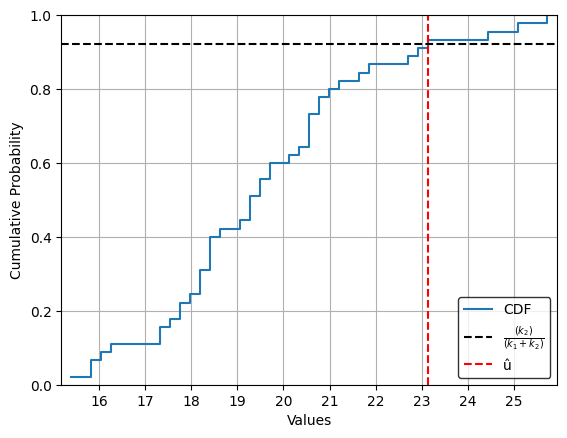

In [8]:
# the provided data, k-values, and k-ratios
X = np.array([18.47, 21.94, 18.59, 15.18, 20.47, 17.36, 18.82, 25.94, 15.88,
17.56, 18.29, 15.90, 22.97, 17.97, 25.15, 23.26, 20.72, 19.61,
20.72, 18.08, 20.65, 19.26, 19.75, 21.30, 20.99, 19.60, 17.51,
16.34, 18.55, 18.22, 20.98, 19.31, 17.87, 21.07, 21.81, 20.13,
18.40, 19.86, 16.09, 20.71, 19.41, 22.88, 18.62, 19.34, 24.61])
k_1 = np.array([20, 0.5])
k_2 = np.array([40, 6])
k = k_2/(k_1 + k_2)

# plot the CDFs, k-ratios, and u-hat values
n_bins = 50
hist_values, bin_edges = np.histogram(X, n_bins)
pdf = hist_values / sum(hist_values)
cdf = np.cumsum(pdf)
for i in range(len(k_1)):
    plt.clf()
    plt.grid()
    plt.step(bin_edges[1:], cdf, label='CDF')
    plt.axhline(y=k[i], c='k', linestyle='--', label=r'$\frac{(k_2)}{(k_1+k_2)}$')
    # interpolate to find the CDF bin edge that intersects the k-ratio
    n = np.interp(k[i], cdf, bin_edges[1:])
    u = [x for x in bin_edges-n if x < 0][-1]+n
    plt.axvline(x=u, c='r', linestyle='--', label='û')
    plt.xlim(bin_edges[0], bin_edges[-1])
    plt.xticks(np.linspace(math.ceil(bin_edges[0]), math.floor(bin_edges[-1]), 10))
    plt.xlabel('Values')
    plt.ylim(0, 1)
    plt.ylabel('Cumulative Probability')
    plt.legend(loc='best', edgecolor='k')
    plt.savefig(os.path.join(out_dir, 'pset2p2.5.' + str(i+1) + '.png'), bbox_inches='tight')

# Question 3

## 3.1

In [9]:
df = load_data()
our_penguin = "Gentoo"
gentoo = df[df['species'] == our_penguin]

In [10]:
gentoo

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
219,Gentoo,Biscoe,46.1,13.2,211,4500,FEMALE
220,Gentoo,Biscoe,50.0,16.3,230,5700,MALE
221,Gentoo,Biscoe,48.7,14.1,210,4450,FEMALE
222,Gentoo,Biscoe,50.0,15.2,218,5700,MALE
223,Gentoo,Biscoe,47.6,14.5,215,5400,MALE
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214,4925,FEMALE
338,Gentoo,Biscoe,46.8,14.3,215,4850,FEMALE
339,Gentoo,Biscoe,50.4,15.7,222,5750,MALE
340,Gentoo,Biscoe,45.2,14.8,212,5200,FEMALE


In [17]:
gentoo['body_mass_g'].mean() / 100

np.float64(50.760162601626014)

## 3.2

In [116]:
class PenguinModel():

    def __init__(self):
        self.alpha_prior = self.assign_alpha_prior()
        self.beta_prior = self.assign_beta_prior()
        self.sigma_prior = self.assign_sigma_prior()
        self.likelihood = None

    # define model attributes
    def assign_alpha_prior(self, loc: float=0, scale: float=1):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_beta_prior(self, loc: float=1.5, scale: float=.25):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_sigma_prior(self, s: float=1, scale: float=0):
        return sp.stats.lognorm(s=s, scale=np.exp(scale))

    def assign_likelihood(self, loc, scale):
        mod = sp.stats.norm(loc=loc, scale=scale)
        self.likelihood = mod


    # define methods
    def bootstrap(self, X: pd.Series, stat=np.mean, n_resamples: int=1000,
            random_state: np.random.RandomState=np.random.default_rng()
    ) -> np.array:
        """Bootstrap a vector `X` about the mean.

        Args:
            X (pd.Series): Input data.
            stat (callable, optional): Bootstrap statistic. Defaults to np.mean.
            n_resamples (int, optional): Number of bootstrap samples. Defaults to 1000.
            random_state (np.random.RandomState, optional): Random number generator. 
                Defaults to np.random.default_rng().

        Returns:
            np.array: Distribution of length `n_resamples`.
        """
        res = sp.stats.bootstrap(X, 
                                 stat, 
                                 random_state=random_state,
                                 n_resamples=n_resamples)
        return res.bootstrap_distribution
    
    def simulate_prior_predictive(self, X: pd.Series):
        """Simulate prior-predictive distribution.

        Args:
            X (pd.Series): Input data.  

        Returns:
            X_hat (np.array): Bootstrapped input data.
            y_tilde (np.array): Predicted `Y`
            alpha (np.array): Simulated values of `alpha`.
            beta (np.array): Simulated values of `beta`.
        """
        X_hat = self.bootstrap((X, ))

        n_prior_samples = len(X_hat)

        alpha = self.alpha_prior.rvs(size=n_prior_samples)
        beta = self.beta_prior.rvs(size=n_prior_samples)
        sigma = self.sigma_prior.rvs(size=n_prior_samples)
        mu = alpha + beta * X_hat

        self.assign_likelihood(loc=mu, scale=sigma)
        y_tilde = self.likelihood.rvs(size=n_prior_samples)

        return X_hat, y_tilde, alpha, beta

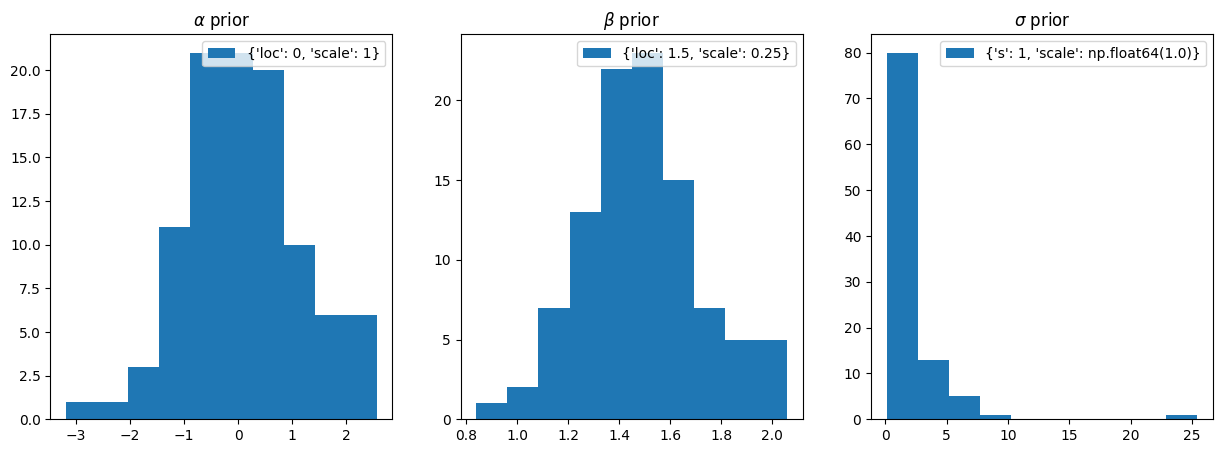

In [117]:
def plot_priors(model: PenguinModel, n_prior_vals: int=100) -> None:
    """Plot PenguinModel prior distributions using default values.

    Args:
        model (PenguinModel): PenguinModel object  
        n_prior_vals (int, optional): Values of each prior distribution to plot. 
            Defaults to 100.
    """
    plt_dict = {
        r'$\alpha$ prior': model.alpha_prior,
        r'$\beta$ prior': model.beta_prior,
        r'$\sigma$ prior': model.sigma_prior
    }

    fig, axs = plt.subplots(ncols=len(plt_dict), figsize=(15, 5))
    
    for (k, v), ax in zip(plt_dict.items(), axs):
        dist = v.rvs(n_prior_vals)
        labs = v.kwds
        ax.hist(dist, label=labs)
        ax.set_title(k)
        ax.legend()    

n_prior_vals = 100
model = PenguinModel()
plot_priors(model, n_prior_vals)
plt.savefig(os.path.join(out_dir, 'prior_distributions.pdf'), bbox_inches='tight')

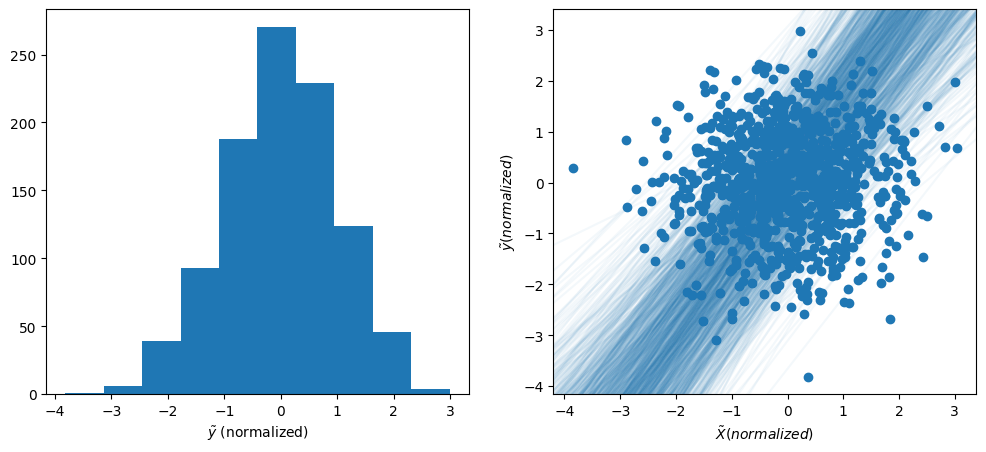

In [119]:
def scale(Y):
    return (Y - np.mean(Y)) / np.std(Y)

def plot_prior_predictive(model: PenguinModel, X: pd.Series) -> None:
    """Plot simulated prior predictive y-tilde and linear slopes.

    Args:
        model (PenguinModel): PenguinModel object.
        X (pd.Series): Input data (passed to `PenguinModel.simulate_prior_predictive()`)
    """
    X_tilde, y_tilde, alpha, beta = model.simulate_prior_predictive(X)

    y_tilde_norm = scale(y_tilde)
    X_tilde_norm = scale(X_tilde)

    fig, axs = plt.subplots(ncols=2, figsize= (12, 5))
    
    ax = axs[0]
    ax.hist(y_tilde_norm)
    ax.set_xlabel(r'$\tilde{y}$ (normalized)')

    ax = axs[1]
    # print(alpha + beta * X_tilde)

    # for i in range(len(alpha)):
    #     ax.plot(X_tilde_norm, alpha[i] + beta[i] * X_tilde, alpha=.05, color='black')
    ax.scatter(X_tilde_norm,  y_tilde_norm)
    for i in range(len(alpha)):
        xy1 = (0, alpha[i])
        slope = beta[i]

        ax.axline(xy1=xy1, slope=slope, alpha=.05)
    # plt.line(a)

    ax.set_xlabel(r'$\tilde{X} (normalized)$')
    ax.set_ylabel(r'$\tilde{y} (normalized)$')

plot_prior_predictive(model, df['flipper_length_mm'])
plt.savefig(os.path.join(out_dir, 'prior_predictive.pdf'), bbox_inches='tight')

In [56]:


def log_posterior(model, X, Y):

    N = len(X)
    
    



def log_posterior(model, X):
    
    mu = model.alpha_prior.pdf(X) + model.beta_prior.pdf(X) * X
    sigma2 = model.sigma_prior.pdf(X)

    model.assign_likelihood(mu, sigma2)
    log_likelihood = model.likelihood.logpdf(X)

    log_prior_mu = model.alpha_prior.logpdf(X) + model.beta_prior.logpdf(X) * np.log(X)
    log_prior_sigma = model.sigma_prior.logpdf(X) 

    return log_likelihood + log_prior_sigma + log_prior_mu
log_posterior(model, df['flipper_length_mm'])


0     -1.838229e+21
1     -2.723337e+21
2     -5.403060e+21
3     -4.651137e+21
4     -3.705436e+21
           ...     
337   -2.107412e+22
338   -2.257285e+22
339   -3.623681e+22
340   -1.835321e+22
341   -1.966942e+22
Name: flipper_length_mm, Length: 342, dtype: float64

In [59]:
# initial_guess = np.array([np.mean(X), np.std(X)])
# initial_guess

array([200.91520468,  14.04114057])

# Exercise 4 #

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd
import networkx as nx
from collections import Counter
sns.set_style('ticks')
%matplotlib inline

In [60]:
def create_Z_support(support_size=10, vec_length=10):
    
    Z = np.random.randint(2, size=(vec_length, support_size))
    return Z

Z = create_Z_support()
print(Z)

[[1 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 1 0 0]
 [1 1 1 0 0 1 1 0 1 0]
 [1 1 1 0 0 1 0 1 1 0]
 [0 0 0 1 0 0 1 1 1 1]
 [0 0 1 1 0 0 0 0 0 1]
 [1 1 1 0 1 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 1 1]
 [1 1 0 0 0 1 0 1 0 1]
 [0 0 1 1 1 1 1 0 1 0]]


In [65]:
# 4.1 - Proposal Distribution P
from sklearn.preprocessing import normalize
def create_proposal_distr_P(support_size=10, vec_length=10):
    
    # Create P and normalize
    P = (np.random.random(support_size*vec_length)
        .reshape(vec_length,support_size)
        .astype(np.float64)
    )
    P /= P.sum(axis=0, keepdims=True) 

    return P

P = create_proposal_distr_P(support_size=10, vec_length=10)
P

array([[0.05381665, 0.14616521, 0.07919751, 0.02501904, 0.06312017,
        0.19854422, 0.10711473, 0.07955841, 0.03465033, 0.17861092],
       [0.16257813, 0.05042208, 0.01466835, 0.01602676, 0.02220258,
        0.11749562, 0.15799084, 0.09496354, 0.17538489, 0.08075653],
       [0.14034273, 0.1311031 , 0.03641799, 0.10223517, 0.11754419,
        0.01430267, 0.06150117, 0.1022388 , 0.20727642, 0.08594491],
       [0.16162898, 0.07739783, 0.16671837, 0.16852056, 0.16352392,
        0.08313802, 0.10279751, 0.12044206, 0.08684151, 0.026137  ],
       [0.01853046, 0.00298644, 0.18286779, 0.06692962, 0.03901037,
        0.14890774, 0.05443756, 0.09674168, 0.03381237, 0.17382386],
       [0.16866502, 0.15473386, 0.08515501, 0.21577149, 0.02653656,
        0.00174372, 0.00339757, 0.11214195, 0.09475036, 0.09382009],
       [0.00147816, 0.07571743, 0.15032213, 0.12529583, 0.13505072,
        0.0471422 , 0.13832262, 0.1124917 , 0.04385178, 0.04287351],
       [0.12438831, 0.14867018, 0.0870085

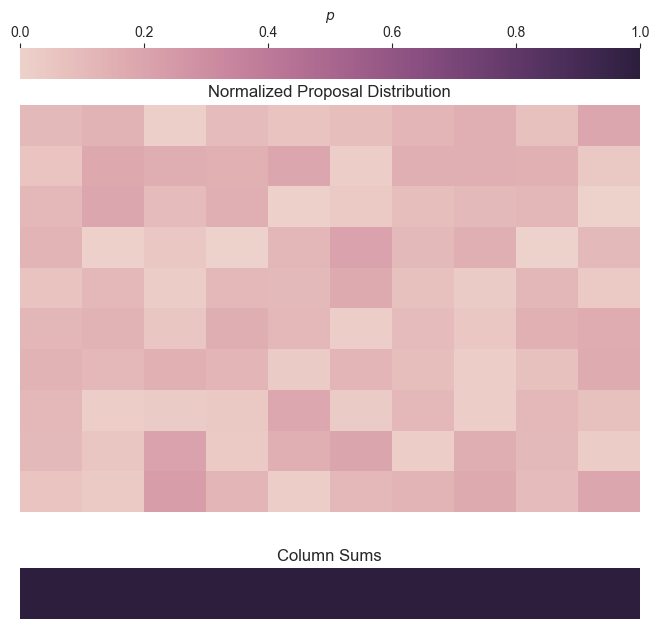

In [130]:
def plot_proposal_distribution(P: np.array) -> None:
    """Create plot for probability proposal distribution.

    Args:
        P (np.array): Normalized probabilities from `create_proposal_distr_P`
    """

    fig, axs = plt.subplots(ncols=1, nrows=2, height_ratios=[10, 1],
                            figsize=(8, 8))

    cmap = sns.cubehelix_palette(as_cmap=True)

    cbar_kwds = {'location': 'top', 'label': r'$p$'}

    ax = axs[0]

    sns.heatmap(data=P, 
                ax=ax, 
                cmap=cmap, cbar_kws=cbar_kwds, 
                vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title("Normalized Proposal Distribution")

    ax = axs[1]
    colsums = np.sum(P, axis=0)
    sns.heatmap(data=[colsums], cmap=cmap, ax=ax, cbar=False, vmin=0, vmax=1)

    ax.set_axis_off()
    ax.set_title("Column Sums")

plot_proposal_distribution(P)
plt.savefig(os.path.join(out_dir, "proposal_distribution.pdf"), bbox_inches='tight')


In [109]:
def propose_next_state(Z, P, init_state):
    """
        Return a proposed move move based on current state.

        Parameters
        ----------
            
        Z : np.array
            The matrix of z support vectors.
            
        P : np.array
            The matrix of transition probabilities. Normalized by columns.
            
        init_state : int
            The current state, stored as the row index wrt Z support
            
        Returns
        --------
        
        next_state_row: np.array
            The next states, stored as the vector given by the support Z
            
        next_state_row_idx: int
            The next state, stored as the row index wrt Z support 
        
    """
    
    # states are represented by integers indexed at 0, stored in STATE_SPACE
    next_state_row_idx = np.random.choice(Z.shape[0], p=P[:, init_state])
    next_state_row = Z[next_state_row_idx, :]
    return next_state_row, next_state_row_idx

In [110]:
def metropolis_hastings(support_size, vec_length, T=1000):
    """Run the MH algorithm"""
    
    # Create the support Z
    Z = create_Z_support(support_size, vec_length)
    P = create_proposal_distr_P(support_size, vec_length)
    
    # Init State
    proposed_state_idx = 0
    init_state, init_state_idx = propose_next_state(Z, P, init_state=int(proposed_state_idx))
    
    # Trackers
    states = []
    prob_accumulator = []
    states.append((init_state, init_state_idx))
    
    for t in range(T):
        # Sample state
        i_state, i_state_idx = states[-1]
        i_sum = np.sum(i_state)
  
        # generate proposal
        j_state, j_state_idx = propose_next_state(Z, P, i_state_idx)
        j_sum = np.sum(j_state)
    
        # calculate acceptance prob.
        A = min(1, (P[i_state_idx, j_state_idx] * j_sum) / (P[j_state_idx, i_state_idx] * i_sum))
        
        # Transition threshold
        t_rand  = np.random.rand()

        if t_rand < A:
            # accept
            states.append((j_state, j_state_idx))
            
            # store result
            prob_accumulator.append(j_state_idx)
        else:
            states.append((i_state, i_state_idx))
            
            # store result
            prob_accumulator.append(i_state_idx)
            
    return Z, P, states, prob_accumulator

time_steps = 1000
support_size = 10
vec_length = 10
Z, P, states, prob_accumulator = metropolis_hastings(support_size, vec_length, time_steps)
states_idx = [idx for _, idx in states]
states_lists = [state for state, _ in states]


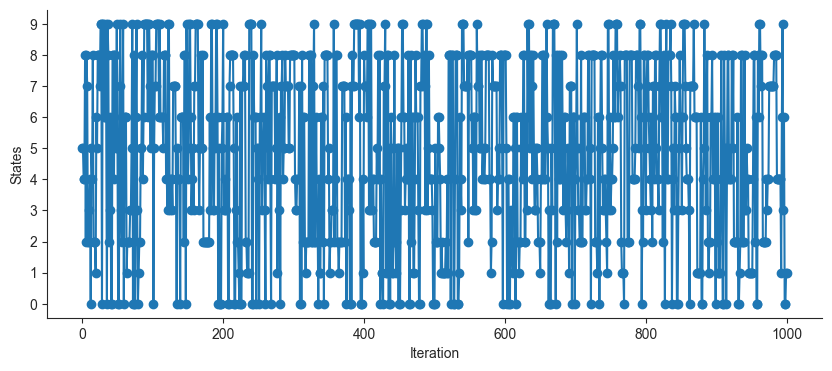

In [111]:
def plot_walk(samples):
    plt.figure(figsize=(10,4))
    plt.plot(samples, marker='o')
    ticks = np.arange(0, 10, 1)
    plt.yticks(ticks)
    sns.despine()
    plt.xlabel('Iteration')
    plt.ylabel('States')

plot_walk(states_idx)
plt.savefig(os.path.join(out_dir, "walk_plot.pdf"), bbox_inches='tight')

In [163]:
def calc_prob_over_8(accumulator, states_lists, time_steps):
    for i in range(Z.shape[0]):
        
        print(f"State {i} was proposed {(Counter(accumulator)[i] / time_steps * 100):.2f}% of the time")
        
    states_over = [states for states in states_lists if np.sum(states) > 8]
    over_8 = (len(states_over) / time_steps) * 100
    
    print(f"\nProbability of P(Z=z) > 8: {over_8:.2f}%")
        
        
calc_prob_over_8(prob_accumulator, states_lists, time_steps)

State 0 was proposed 11.50% of the time
State 1 was proposed 3.10% of the time
State 2 was proposed 8.00% of the time
State 3 was proposed 12.60% of the time
State 4 was proposed 9.60% of the time
State 5 was proposed 10.60% of the time
State 6 was proposed 11.10% of the time
State 7 was proposed 16.50% of the time
State 8 was proposed 6.90% of the time
State 9 was proposed 10.10% of the time

Probability of P(Z=z) > 8: 0.00%


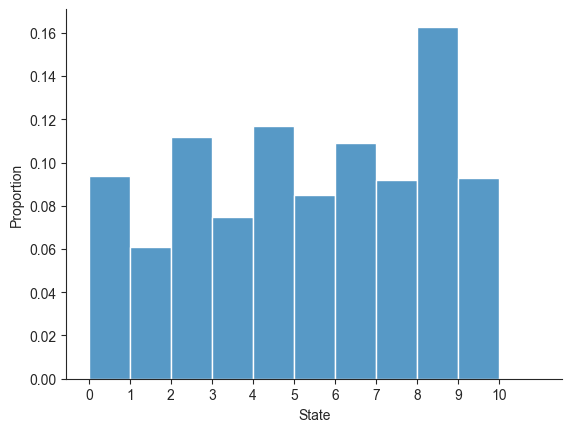

In [124]:

def plot_transition_heatmap(Z,  samples, title="Transition Heatmap Based on Sums"):
    """
    Plot a heatmap showing the transitions between different sums of the binary vectors.
    Each cell (i, j) in the heatmap represents the number of times the chain moved from a state with sum i to a state with sum j. 

    Parameters:
    - Z (np.ndarray): The support matrix.
    - samples (list): List of sampled state indices.
    - title (str): Title of the plot.
    """
    # Compute the sum of each sampled state
    sums = [Z[idx].sum() for idx in samples]
    
    # Compute transitions
    transitions = {}
    for i in range(1, len(sums)):
        prev_sum = sums[i-1]
        curr_sum = sums[i]
        transitions[(prev_sum, curr_sum)] = transitions.get((prev_sum, curr_sum), 0) + 1
    
    # Prepare data for heatmap
    max_sum = Z.shape[1]
    heatmap_data = np.zeros((max_sum+1, max_sum+1), dtype=int)
    for (prev, curr), count in transitions.items():
        heatmap_data[prev, curr] = count
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(0, max_sum+1), 
                yticklabels=range(0, max_sum+1))
    plt.title(title)
    plt.xlabel('Current Sum')
    plt.ylabel('Previous Sum')
    # plt.show()
    
def plot_sum_distribution(Z, samples, title="Distribution of the Number of Ones in Sampled Vectors"):
    """
    Plot a histogram of the number of ones in the sampled vectors.

    Parameters:
    - Z (np.ndarray): The support matrix.
    - samples (list): List of sampled state indices.
    - title (str): Title of the plot.
    """
    sums = [Z[idx].sum() for idx in samples]
    plt.figure(figsize=(10, 6))
    sns.histplot(sums, bins=range(0, Z.shape[1]+2), kde=False, stat='probability', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Ones')
    plt.ylabel('Probability')
    plt.xticks(range(0, Z.shape[1]+1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.show()
    
def plot_state_proportion(states_idx):
    # plt.figure(figsize=(15,14))
    sns.histplot(states_idx, bins=range(0, Z.shape[1]+2), stat='proportion')
    plt.xticks(range(0, Z.shape[1]+1))
    plt.xlabel('State');
    sns.despine()

plot_state_proportion(states_idx)
plt.savefig(os.path.join(out_dir, 'state_probability.pdf'), bbox_inches='tight')

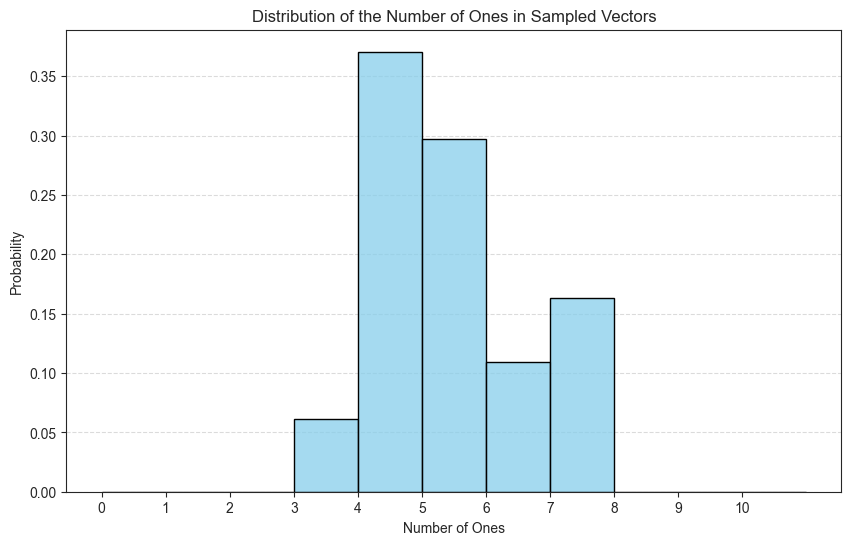

In [118]:
plot_sum_distribution(Z, samples=states_idx)
plt.savefig(os.path.join("ones_distribution.pdf"), bbox_inches='tight')

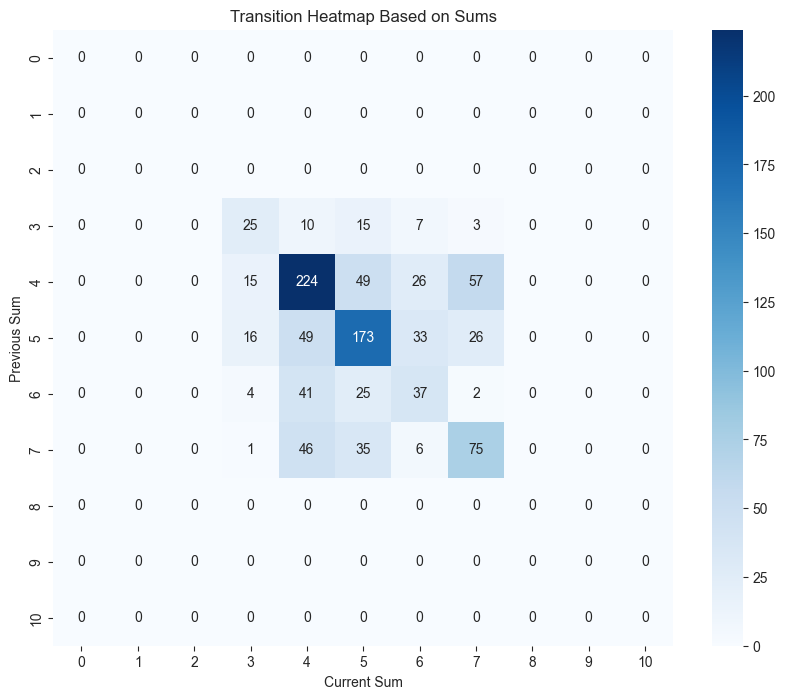

In [119]:
plot_transition_heatmap(Z, samples=states_idx)
plt.savefig(os.path.join(out_dir, 'transition_heatmap.pdf'), bbox_inches='tight')